# Limpando Dados do OpenStreetMap - Cidade de São Paulo 

In [1]:
from IPython.display import Image
Image(url="http://revistainfra.com.br/arquivos/Ponte%20Estaiada_HRSG2M.jpg")

# Introdução

Neste projeto será executado algumas tarefas de auditoria e limpeza de dados, disponível na plataforma colaborativa OpenStreetMap (Mapzen), da Região Metropolitana da cidade de São Paulo, utilizando como ferramentas a linguagem Python e o banco de dados MongoDB.

O OpenStreetMap é um projeto aberto, gratuito, concorrente direto do Google Maps e todos podem usá-lo e editá-lo como quiserem. Por esse motivo, erros como abreviação de nomes de ruas, CEP's incompletos e identificações errôneas são comuns de serem encontrados. Este projeto tem por objetivo identificar e corrigir alguns desses problemas e transformá-los em um padrão mais estruturado.

**Tipo de Dado e Características OSM XML**

Para este trabalho utilizarei o arquivo **sao-paulo_brazil.osm**, da área metropolitana de São Paulo baixado no formato OSM XML. Algumas características dos elementos do formato OSM XML é interessante ressaltar:

* OSM XML é uma lista de instâncias de dados primitivos de nós, caminhos e relações (_nodes, ways and relations_) encontrados dentro de um dado limite: 

> Nós (< _nodes_ >) - representam pontos adimensionais no mapa, possuem atributos de longitude (_"lon"_) e latitude (_"lat"_) para coordenadas e pode conter 0 ou mais sub-elementos < _tag_ >.

> Caminhos (< _ways_ >) - especifica os caminhos como o próprio nome diz. Contém, por ordem, sub-elementos < _nd_ > referenciando nós, e 0 ou mais < _tag_ >'s.

> Nós e caminhos (< _nodes_ > and < _ways_ >) - ambos contêm elementos de tag filhos (_children tags_) que representam pares de valores-chave de informações descritivas sobre um determinado nó ou caminho.

> Relações (< _relations_ >) - especifica algumas relações lógicas entre outros objetos como por exemplo, a rota de um ônibus, a área que envolve uma floresta, instruções de trânsito como _"no left turn here"_. Contém sub-elementos < _member_ > referenciando os outros objetos que compõem o relacionamento, e 0 ou mais < _tag_ >'s.

* Há três sub-elementos que nunca contêm mais elementos:

> Etiqueta < _tag_ > - é um par chave/valor (key/value) armazenado como atributos "k" e "v".

> Referência < _nd_ > - referencia um nó e contém apenas o atributo _'ref'_.

> Membro < _member_ > - contém atributos _'ref'_, _'type'_ e o _'role'_ e descreve o papel que o membro tem no relacionamento.

* Há algumas identificações como:

> _'id'_ - é uma identificação única dentro de cada tipo.

> _'uid'_ - mostra o último usuário que modificou o objeto.

> _'timestamp'_ - é um carimbo de data/hora da última modificação.

> _'version'_ e _'changeset number'_ - versão, que sempre aumenta na última edição, e o número do conjunto de alterações.

**Mapa da região**

Abaixo temos um mapa da cidade de São Paulo.

In [1]:
import IPython.display as display
osm = """
<iframe width="425" height="350" frameborder="0" scrolling="no" marginheight="0" marginwidth="0" \
src="http://www.openstreetmap.org/export/embed.html?bbox= \
-46.767082214355476%2C-23.65112855857962%2C-46.53705596923828%2C-23.466395647408074&amp;layer=mapnik" \
style="border: 1px solid black"></iframe><br/><small><a \
href="http://www.openstreetmap.org/#map=12/-23.5588/-46.6521">View Larger Map</a></small>
"""
display.HTML(osm)

Abaixo temos os pacotes utilizados para as análises.

In [2]:
%pylab inline
import xml.etree.ElementTree as ET
import xml.etree.cElementTree as ET
from collections import defaultdict
from pymongo import MongoClient
from operator import itemgetter
from difflib import get_close_matches
import re
import time
import pprint
import codecs
import json

Populating the interactive namespace from numpy and matplotlib


C:\Users\Lourdes\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Há várias possibilidades e caminhos em um processo de auditoria, mas irei auditar e limpar somente os tipos de vias seguindo a rubrica deste projeto. 

E após o processo será criado um documento tipo JSON para a consulta interna dos dados através do MongoDB. O MongoDB é um banco de dados NoSQL orientado a documentos de alta performance, open source e schema-free, escrito em C++. Ele é uma mistura entre os repositórios escaláveis baseados em chave/valor e a tradicional riqueza de funcionalidades dos bancos relacionais (Nascimento, 2010).

# Auditoria dos dados

Nosso conjunto de dados possui 869MB descompactado e para facilitar o processo de auditoria o código abaixo irá gerar uma amosta base bem menor (sample.osm) que será passado para o arquivo como um todo, dando agilidade no processo sem sobrecarregar o sistema.

In [3]:
#import xml.etree.ElementTree as ET  # use cElementTree or lxml if too slow

osmfile = "C:\\Users\\Lourdes\\Downloads\\Extra Dados\\P3\\4 OSM XML\\sao-paulo_brazil.osm"  # replace this with your osm file
samplefile = "C:\\Users\\Lourdes\\Downloads\\Extra Dados\\P3\\4 OSM XML\\sample.osm"

k = 10 # parameter: take every k-th top level element. Faz uma iteração dentro do XML buscando as tags node, way and relation.

def get_element(osmfile, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag. Faz o processamento linha a linha.

    Reference:
    http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python
    """
    context = iter(ET.iterparse(osmfile, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem  # este comando nunca carregará o arquivo inteiro dentro da memória da máquina - faz a leitura por partes.
            root.clear()


with open(samplefile, 'wb') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')

    # Write every kth top level element
    for i, element in enumerate(get_element(osmfile)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8'))
          
    output.write('</osm>')

**Visão geral dos dados**

Precisamos conhecer bem os dados visualizando de forma geral as etiquetas, ruas, números de residencias, nós, código postal, enfim, compreender pontualmente as estruturas e os problemas que compõem os dados para facilitar o processo de auditoria. Na célula abaixo identifiquei os elementos exclusivos e a saída mostra os tipos e a quantidade de vezes que se repetem.

In [4]:
#import xml.etree.ElementTree as ET - já carregado acima 
#import pprint

tags = {}

for event, elem in ET.iterparse(samplefile):  
    if elem.tag in tags: tags[elem.tag] += 1
    else:                tags[elem.tag] = 1

pprint.pprint(tags)

{'member': 6996,
 'nd': 544285,
 'node': 402276,
 'osm': 1,
 'relation': 1185,
 'tag': 180055,
 'way': 55632}


**Verificando os valores de k**

Verificar os valores de k nos dará uma ideia de quantos parâmetros estamos lidando. Abaixo foram gerados alguns dados como:
- 'lower' - para etiquetas que contêm apenas letras minúsculas e são válidas;

- 'lower_colon' - para outras tags válidas com um dois pontos ':' em seus nomes;

- 'Problemchars' - para etiquetas com caracteres problemáticos;

- 'other' - para outras tags que não se enquadram nas outras três categorias.

In [5]:
#import xml.etree.cElementTree as ET
#import re
#import pprint

lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

def key_type(element, keys):
    if element.tag == 'tag':
        try:
            lowermo = lower.search(element.attrib['k'])
            lowermo.group()
            keys["lower"] += 1
        except AttributeError:
            try:
                lower_colonmo = lower_colon.search(element.attrib['k'])
                lower_colonmo.group()
                keys["lower_colon"] += 1
            except AttributeError:
                try:
                    problemcharmo = problemchars.search(element.attrib['k'])
                    problemcharmo.group()
                    keys["problemchars"] += 1
                except AttributeError:
                    keys["other"] += 1
    return keys

def process_map_tagtypes(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other":0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)
    return keys

keys = process_map_tagtypes(samplefile)

pprint.pprint(keys)

{'lower': 165926, 'lower_colon': 13966, 'other': 163, 'problemchars': 0}


**Usuários**

O código abaixo nos dá a relação de quantos usuários contribuíram com o OSM de SP até a data em que foi baixado.

In [6]:
def get_user(element):
    return


def process_map_users(filename):
    users = set()
    for _, element in ET.iterparse(filename):
        for key in element.attrib:
            if key == 'uid':
                users.add(element.attrib[key])
    return users

users = process_map_users(samplefile)

len(users)

1323

Temos o total de 1.323 pessoas que contribuíram com algum tipo de registro através da plataforma colaborativa para formar o banco de dados com os endereços do município.

A partir deste ponto começaremos a observar quais tipos de problemas poderemos encontrar durante a exploração e auditoria dos dados.

**Nodes - visualizando problemas**

Foi possível visualizar alguns problemas com relação aos nodes do conjunto de dados em questão, através do site Osmose do Openstreetmap (http://osmose.openstreetmap.fr/en/map/), gerando um mapa da área central de São Paulo é possível ver que há tags faltantes, tags classificadas como ruins, há tags também para serem removidas, entre outras coisas. É interessante poder visualizar os dados no mapa que a plataforma oferece e não somente na saída dos programas gerados, visto que facilita a compreensão das análises.

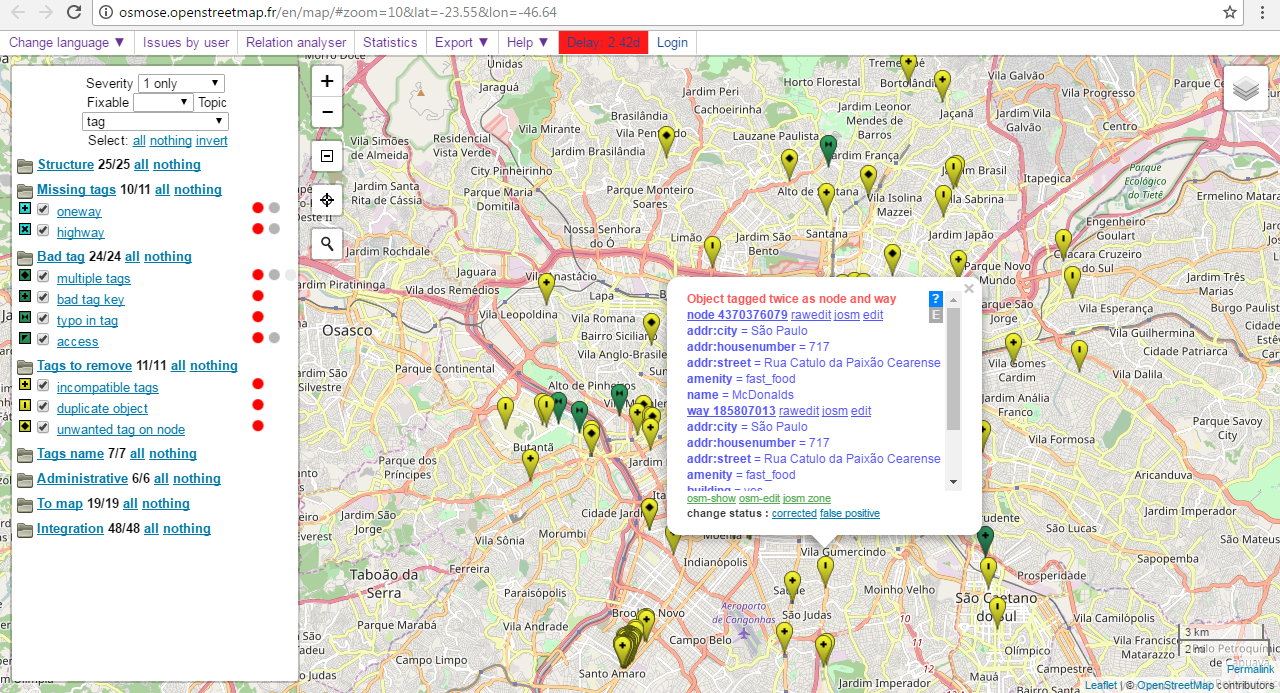

In [5]:
from IPython.display import Image
Image(filename='OsmoseTag.png')

O trecho abaixo foi retirado da ilustração acima e corresponde à Rua Catulo da Paixão Cearense, no qual revela que o objeto foi etiquetado duas vezes como node e way.

Os marcadores JSON com latitude e longitude, mostrado abaixo, servem como exemplo e são formas identificadoras dos erros e dos itens do mapa mostrado acima.

**Nodes - explorando atributos**

Iniciaremos explorando os atributos associados aos nodes dos dados OSM XML. Em seguida construiremos um dicionário que receberá todas as informações relativas a cada node.

In [7]:
count_node = 0
for event, elem in ET.iterparse(samplefile, events=("start",)):
    if elem.tag == "node":
        if count_node > 5:
            break
        for tag in elem.iter():
            count_node += 1
            print(tag.attrib)

{'changeset': '45830355', 'uid': '2030995', 'timestamp': '2017-02-05T14:23:45Z', 'lon': '-46.7072495', 'version': '4', 'user': 'Bonix-Mapper', 'lat': '-23.5594985', 'id': '573640'}
{'changeset': '19327000', 'uid': '251808', 'timestamp': '2013-12-07T18:08:38Z', 'lon': '-46.7020748', 'version': '5', 'user': 'cxs', 'lat': '-23.5718306', 'id': '577239'}
{'changeset': '18428865', 'uid': '1517646', 'timestamp': '2013-10-19T05:34:40Z', 'lon': '-46.7302882', 'version': '5', 'user': 'josedeonesio', 'lat': '-23.5500816', 'id': '582142'}
{'changeset': '158329', 'uid': '1596', 'timestamp': '2007-07-21T22:13:40Z', 'lon': '-46.8051032', 'version': '1', 'user': 'Claudomiro', 'lat': '-23.5115537', 'id': '582153'}
{'changeset': '21449735', 'uid': '401472', 'timestamp': '2014-04-02T02:43:16Z', 'lon': '-46.7373806', 'version': '4', 'user': 'ftrebien', 'lat': '-23.4866087', 'id': '582452'}
{'changeset': '220564', 'uid': '1596', 'timestamp': '2007-02-20T13:39:08Z', 'lon': '-46.7694281', 'version': '1', 'us

Em seguida, para a consolidação dos nodes será feita uma lista de dicionários.

In [8]:
node_list = list() # lista de dicionários
node_dict = {} # dicionário que receberá a informação de cada node
attrib_nodes = ('id' and 'changeset' and 'user' and 'uid' and 'version' and 'timestamp' and 'lon' and 'lat') #atributos dos nodes

Processo que irá percorrer os nodes e construir dicionários com informações e adicioná-los a lista.

In [9]:
for event, elem in ET.iterparse(samplefile, events=("start",)):
    if elem.tag == "node":
        for tag in elem.iter():
            if len(node_dict) == 0 and attrib_nodes in tag.attrib:
                node_dict['id'] = tag.attrib['id']
                node_dict['lat'] = tag.attrib['lat']
                node_dict['lon'] = tag.attrib['lon']
                node_dict['user'] = tag.attrib['user']
                node_dict['uid'] = tag.attrib['uid']
                node_dict['version'] = tag.attrib['version']
                node_dict['changeset'] = tag.attrib['changeset']
                node_dict['timestamp'] = tag.attrib['timestamp']             
                node_list.append(node_dict)
            elif len(node_dict) != 0 and attrib_nodes in tag.attrib:
                node_dict = {}
                node_dict['id'] = tag.attrib['id']
                node_dict['lat'] = tag.attrib['lat']
                node_dict['lon'] = tag.attrib['lon']
                node_dict['user'] = tag.attrib['user']
                node_dict['uid'] = tag.attrib['uid']
                node_dict['version'] = tag.attrib['version']
                node_dict['changeset'] = tag.attrib['changeset']
                node_dict['timestamp'] = tag.attrib['timestamp']
                node_list.append(node_dict)

In [10]:
node_list[0:2] # amostra dos dados da lista

[{'changeset': '45830355',
  'id': '573640',
  'lat': '-23.5594985',
  'lon': '-46.7072495',
  'timestamp': '2017-02-05T14:23:45Z',
  'uid': '2030995',
  'user': 'Bonix-Mapper',
  'version': '4'},
 {'changeset': '19327000',
  'id': '577239',
  'lat': '-23.5718306',
  'lon': '-46.7020748',
  'timestamp': '2013-12-07T18:08:38Z',
  'uid': '251808',
  'user': 'cxs',
  'version': '5'}]

**Tags - visualizando problemas**

Para visualizar alguns problemas diretamente relacionados aos tags do conjunto de dados, utilizei o site OSM Inspector (http://tools.geofabrik.de/osmi/), pois através da coluna Ovelays pude selecionar os pontos _No addr: street tag_ e _street not found_ e observar que há ruas não encontradas e na coluna Selection podemos ver que os dados dos pontos em evidência não estão completos.

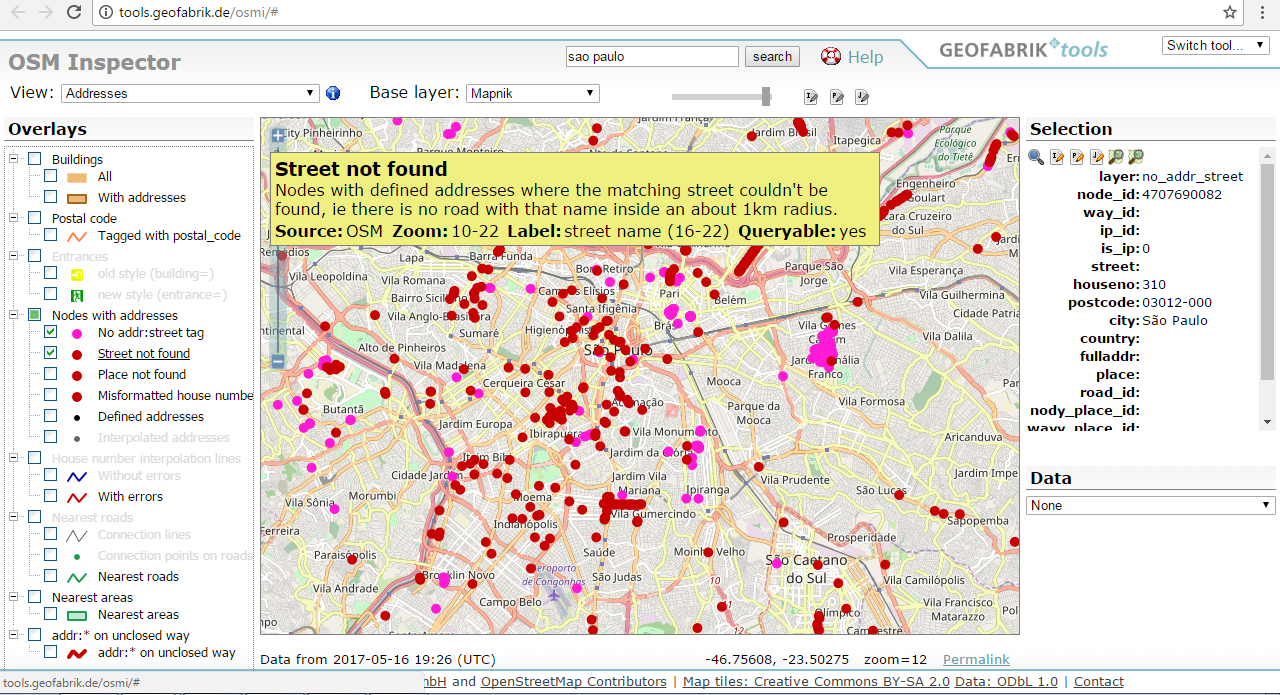

In [9]:
Image(filename='OSMInspector.png')

**Tags - explorando atributos**

Em seguida, será explorado os atributos associados às tags e, posteriormente, será construído um dicionário que receberá todas as informações de cada uma.

In [11]:
count_tag = 0
for event, elem in ET.iterparse(samplefile, events=("start",)):
    if elem.tag == "node":
        for node in elem.iter('node'):
            for tag in elem.iter('tag'):
                if count_tag > 5:
                    break
                count_tag += 1
                print(tag.attrib)

{'k': 'created_by', 'v': 'JOSM'}
{'k': 'created_by', 'v': 'JOSM'}
{'k': 'highway', 'v': 'speed_camera'}
{'k': 'highway', 'v': 'traffic_signals'}
{'k': 'highway', 'v': 'traffic_signals'}
{'k': 'public_transport', 'v': 'stop_position'}


Cada tag designa um atributo geográfico a uma característica apresentada por um _node_, _way_ ou _relation_ específico. De forma similiar ao anterior, os dados das tags será consolidado.

In [12]:
node_tags_dict = {} # dicionário com os dados individuais das tags
node_tags_list = list() # lista de dicionários

for event, elem in ET.iterparse(samplefile, events=("start",)):
    if elem.tag == "node":
        for node in elem.iter('node'):
            for tag in elem.iter('tag'):
                if len(node_tags_dict) == 0:
                    node_tags_dict['key'] = tag.attrib['k']
                    node_tags_dict['value'] = tag.attrib['v']
                    node_tags_dict['node_id'] = node.attrib['id']
                    node_tags_list.append(node_tags_dict)
                    
                elif len (node_tags_dict) != 0:
                    node_tags_dict = {}
                    node_tags_dict['key'] = tag.attrib['k']
                    node_tags_dict['value'] = tag.attrib['v']
                    node_tags_dict['node_id'] = node.attrib['id']
                    node_tags_list.append(node_tags_dict)

In [13]:
node_tags_list[0:2] # amostra da lista de dicionários

[{'key': 'created_by', 'node_id': '582605', 'value': 'JOSM'},
 {'key': 'created_by', 'node_id': '20944331', 'value': 'JOSM'}]

**Auditando e limpando os tipos de vias**

Os nomes das ruas aparecem em duas formas no conjunto de dados, nos elementos _node_ sob a forma de "< tag k =" addr: street "v =" street_name "/ >",  com a finalidade de registrar o tipo de via com seu respectivo nome, como mostrado no exemplo abaixo.

E também nos elementos _way_ sob a forma de "< tag k =" highway ".... / >", exemplificado logo abaixo.

A célula que vem a seguir verifica os tipos de vias, o total existente, as de maior frequência e a quantidade de registros.

In [14]:
#!/usr/bin/env python
#-*- coding: utf-8 -*-
#import xml.etree.cElementTree as ET
#from collections import defaultdict
#import re

samplefile = open("C:/Users/Lourdes/Downloads/Extra Dados/P3/4 OSM XML/sample.osm", "r")

street_type_re = re.compile(r'^\S+\.?',re.IGNORECASE)
    # Módulo de expressões regulares para comparar uma sequência de caracteres que não sejam espaço em branco,
    # talvez seguido por um ponto - isto é, abreviações ex.: Aven. (Avenida) - no inicio da string (^).
    # Ex. "Rodov. Anhaguera" ou "RoD. ANHAGUERA"
street_types = defaultdict(int)

def audit_street_type(street_types, street_name):
    """     Realiza analise do nome das ruas (street_name) buscando
    pelos tipos existentes na base (street_types).  
    Argumentos:
            Recebe os tipos de ruas válidos e o nome da rua lido           
    Retornos:
            Não possui 
    """
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()

        street_types[street_type] += 1

def print_sorted_dict(d):
    keys = d.keys()
    keys = sorted(keys, key=lambda s: s.lower())
    cont=0;
    contV=0;
    for k in keys:
        v = d[k]
        print "%s: %d" % (k, v) 
        cont+=1
        contV=contV+v
    print cont
    print contV

def is_street_name(elem):
    return (elem.tag == "tag") and (elem.attrib['k'] == "addr:street")

def audit():
    """     Examina o arquivo XML, um tag por vez, utilizando um analisador Sax, de forma a criar um registro
    de todos os street_types encontrados no conjunto de dados.
    Argumentos:
            Não possui           
    Retornos: 
            Não possui 
    """
    for event, elem in ET.iterparse(samplefile):
        if is_street_name(elem):
            audit_street_type(street_types, elem.attrib['v'])    
    print_sorted_dict(street_types)    

if __name__ == '__main__':
    audit()

Alameda: 43
antonio: 1
Av.: 1
avenida: 1
Avenida: 804
Azevedo: 1
Estrada: 30
Largo: 11
Parque: 1
Passeio: 1
Praça: 58
R: 1
R.: 2
Rodovia: 10
Rua: 2214
RUa: 1
rua: 3
Sapopemba: 1
são: 1
Travessa: 20
VERMELHO: 1
Via: 1
Viaduto: 6
Vila: 6
Álvares: 1
25
3220


Vemos então que a saída nos revela 25 tipos de vias distribuídas em um total de 3.220 registros, sendo Rua com uma frequência de 2.214 registros, seguido por Avenida com 804 registros, Praça com 58 registros, Alameda, Estrada e Travessa com respectivamente 43, 30 e 20 registros. De forma menos sigificativa temos, por exemplo, Viaduto, Rodovia, Largo, entre outros com pouquíssimos registros. Uma observação a se fazer é que há casos em que pessoas registraram palavras como avenida e rua com letra minúscula e isso faz com que o programa gere resultados como se fossem palavras diferentes.  

Com os tipos de registros conhecidos, o próximo passo foi auditá-los. Identificando todos os tipos de vias estranhas presente na base, a célula abaixo realizará a modificação para padronizá-las.

In [15]:
#!/usr/bin/env python
#-*- coding: utf-8 -*-
#audit.py
#import xml.etree.cElementTree as ET
#from collections import defaultdict
#import re
#import pprint

arquivo = r"C:\Users\Lourdes\Downloads\Extra Dados\P3\4 OSM XML\sample.osm"

samplefile = open(arquivo, "r")

street_type_re = re.compile(r'^\S+\.?',re.IGNORECASE)
street_types = defaultdict(set)



expected = ["Alameda", "Avenida", "Estrada", "Largo", u"Praça", "Rodovia", "Rua", "Travessa", "Via",
            u"Calçadão", "Rodoanel", "Passeio", u"Complexo Viário", "Marginal"]

mapping = { "Av": "Avenida",
            "Av.": "Avenida",
            "R": "Rua",
            "R.": "Rua", 
            "rua": "Rua",
            "r.": "Rua",
            "r": "Rua",
            "Pr.": u"Praça",
            "PR.": u"Praça",
            "Complexo viário": u"Complexo Viário",
            "Complexo viario": u"Complexo Viário"
          }

def audit_street_type(street_types, street_name):
    """     Utiliza expressão regular para verificar o ínicio do campo "addr:street" identificando assim o Tipo de 
    Via (Rua, Alamenda, etc)
    """
    #print street_name
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        #print street_type 
        if street_type not in expected:
            street_types[street_type].add(street_name)
            
def is_street_name(elem):
    """     Verifica se o tag é um atributo de endereço de via (addr:street). Retorna um Boolean (True se atributo
    de endereço de via)           
    """
    return (elem.attrib['k'] == "addr:street")

def audit():
    """     Realiza análise baseada no evento "tag de ínicio"; quando este ocorre o elemento em questão é 
    identificado e se for do tipo "way", o método "iter" é chamado; este método realiza uma iteração de todas as 
    subtags (tags aninhadas) do tipo "tag".
    """
    for event, elem in ET.iterparse(samplefile, events=("start",)):
        if elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    #pprint.pprint(dict(street_types))
    return street_types

def update_name(name, mapping):
    #print name
    m = street_type_re.search(name)
    other_street_types=[]
    if m:
        street_type = m.group()
        if street_type in mapping.keys():
            name = re.sub(street_type_re, mapping[street_type], name)
        else:
            other_street_types.append(street_type)
        return name

def test():
    st_types = audit()
    print (len(st_types.keys()))
    #pprint.pprint(dict(st_types))
    
    for st_type, ways in st_types.iteritems():
        for name in ways:
            better_name = update_name(name, mapping)
        if name != better_name:
            print name, "=>", better_name
            name= better_name
              
if __name__ == '__main__':
    test()
    samplefile.close()

7
rua Lemos Torres => Rua Lemos Torres
Av. Francisco Nóbrega Barbosa => Avenida Francisco Nóbrega Barbosa
R Dr. Lafaiete de Sousa Camargo => Rua Dr. Lafaiete de Sousa Camargo
R. Fabricio santos de Oliveira => Rua Fabricio santos de Oliveira


C:\Users\Lourdes\Anaconda2\lib\site-packages\ipykernel\__main__.py:71: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


Acima vemos que os nomes foram modificados e corrigidos conforme o esperado. No próximo tópico trataremos do armazenamento dos dados.

# Armazenamento dos Dados

O armazenamento dos dados foi realizado no MongoDB, que é um banco de dados orientado a documentos do tipo JSON. É necessário realizar a conversão dos dados XML para JSON, feito através dos códigos abaixo.

Além da conversão, este programa realiza também a padronização dos tipos de via conforme feito na auditoria das ruas anteriormente.

In [16]:
#import xml.etree.cElementTree as ET
#import pprint
#import re
#import codecs
#import json

osm_file = open("/Users/Lourdes/Downloads/Extra Dados/P3/4 OSM XML/sample.osm", "r")

file_out = "/Users/Lourdes/Downloads/Extra Dados/P3/4 OSM XML/sample2.json"


street_type_re = re.compile(r'^\S+\.?',re.IGNORECASE)

CREATED = [ "version", "changeset", "timestamp", "user", "uid"]

problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

mapping = { "Av": "Avenida",
            "Av.": "Avenida",
            "R": "Rua",
            "R.": "Rua", 
            "rua": "Rua",
            "r.": "Rua",
            "r": "Rua",
            "Pr.": u"Praça",
            "PR.": u"Praça",
            "Complexo viário": u"Complexo Viário",
            "Complexo viario": u"Complexo Viário"
          }

def update_name(name, mapping):
    #print name
    m = street_type_re.search(name)
    other_street_types=[]
    if m:
        street_type = m.group()
        if street_type in mapping.keys():
            name = re.sub(street_type_re, mapping[street_type], name)
        else:
            other_street_types.append(street_type)
        return name

def shape_element(element):
    node = {}
    if element.tag == "node" or element.tag == "way" :
        created = {}
        for e in element.attrib.keys():
            if e in CREATED:
                created[e] = element.attrib[e]
            elif  element.attrib[e] == element.get('lat') or element.attrib[e] == element.get('lon'):
                pos = []
                pos.append(float(element.get('lat')))
                pos.append(float(element.get('lon')))
                node['pos'] = pos
            else:
                node[e] = element.get(e)
                node['type'] = element.tag
        node['created'] = created
        node_refs = []
        address = {}
        for subtag in element:
            if subtag.tag == 'tag':
                if re.search(problemchars, subtag.get('k')):
                    pass
                elif re.search(r'\w+:\w+:\w+', subtag.get('k')):
                    pass
                elif subtag.get('k').startswith('addr:'):
                    address_type = subtag.get('k')[5:]
                    if address_type == 'street':
                        address[address_type] = update_name(subtag.get('v'),mapping)
                    else:
                        address[address_type] = subtag.get('v')
                    node['address'] = address
                else:
                    node[subtag.get('k')] = subtag.get('v')
            else:
                if subtag.tag == 'nd':
                    node_refs.append(subtag.get('ref'))
                else:
                    pass
        if node_refs:
            node['node_refs'] = node_refs
        return node
    else:
        return None
    
def process_map(file_in, pretty = False):
    print file_out
    data = []
    with codecs.open(file_out, "w") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2)+"\n")
                else:
                    fo.write(json.dumps(el) + "\n")
    return data

def test():
   
    data = process_map(osm_file, False)
    #pprint.pprint(data)
    
if __name__ == "__main__":
    test()

/Users/Lourdes/Downloads/Extra Dados/P3/4 OSM XML/sample2.json


C:\Users\Lourdes\Anaconda2\lib\site-packages\ipykernel\__main__.py:37: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


Após criar a base de dados JSON carreguei o arquivo no MongoDB pelo prompt de comando e abaixo estão os resultados das consultas.

# Consultando o JSON

Na consulta do OSM fiz algumas pesquisas superficiais e algumas mais avançadas para verificar os padrões e conhecer um pouco mais do município através destes registros.

> Tamanho da base de dados é de 0.453 GB

Número de documentos da base de dados:

Número de usuários únicos na base:

Contribuição de usuários “bot”:

Número de nós e caminhos encontrado na base:

Número de nós com o nome "Ponto de Ônibus":

Número de estradas e vias na cidade:

Número de pontos de alimentação como restaurantes, cafés e bares:

Número de instituições educacionais:

Número de instituições financeiras:

Número de locais relacionados à saúde como clinicas, dentista, farmácias e hospitais:

Número de locais de recreação como cinema e teatro:

Neste ponto começam as pesquisas mais avançadas.

As 10 amenities que mais aparecem:

Conforme o resultado, temos no top 10 o estacionamento, o combustível (entendo como posto de gasolina), escola, restaurante, fast food, banco, locais de culto, pub, farmácia e hospital, todos com suas frequências de registros.

Sendo assim, vamos explorar um pouco dentro de alguns desses amenities como curiosidade. E como o estacionamento é o que tem mais ocorrências, vamos identificar as 3 maiores capacidade registradas e os tipos mais comuns.

Entre as 3 maiores capacidades temos estacionamentos com capacidades para 50, 200 e 30 veículos como carros, motos e outros. E os tipos mais comuns são; sob o solo, na superfície, de vários andares e dois tipos de garagens (carports e garage_boxes).

Abaixo identifiquei os primeiros 4 registros mais comuns dos bancos, restaurantes, escolas, fast foods e locais de culto.

Quanto aos bancos, os principais registros são Santander, Banco do Brasil, Caixa Econômica e Bradesco, quanto aos restaurantes temos o Subway (registrado de forma errada), O Brasileirinho e a churrascaria Chapão Gaúcho (escrito de forma errada), quanto às escolas temos o Colégio Objetivo, Joaquim Novaes e Caraguava II (provavelmente a mesma escola registrada duas vezes). Quanto ao fast food temos o Subway (registrado de forma certa), o McDonald's e a Lanchonete (sem nome definido), e quanto aos locais de culto temos a Universal do Reino de Deus, a Congregação Cristã no Brasil e a Comunidade Santo Antonio. 

Há três pontos curiosos na consulta acima para ressaltar, o primeiro é que pelo menos um nome foi identificado com a grafia errada, o segundo é que há muitos registros nulos entre as categorias, porque as pessoas se esqueceram ou não pesquisaram os nomes para registrar e o terceiro é que o fast food Subway também foi registrado na categoria restaurante e isso levanta a hipótese de que possivelmente hajam outros registros repetidos que não foram identificados, em pelo menos duas categorias diferentes.

Agora vamos saber quais seriam as alimentações e pratos mais comuns em restaurantes, fast food, pubs e cafés registrados:

Dentre os registros mais comuns, de forma geral, encontramos as alimentações regionais, pizzas, japonesas, italianas, sanduíches, entre outros.

Na pesquisa abaixo, foi verificado os 10 websites mais comuns em nosso banco de dados:

Podemos ver que o website da farmácia Drogasil aparece quatro vezes, seguido pela Diocese de Osasco, hospital Orthoservice (registrado em clínica), São Bernardo do Campo (estranho isso), hospital Sino-Brasileiro, clínicas Fleming Diagnósticos e Ghelfond Diagnósticos, Luteranos, centro de artes do município de Salto (não entendi esse também) e por fim, Museu da Cidade, todos com dois registros cada. É curioso termos websites de municípios diferentes registrados no banco de dados da cidade de São Paulo.

Finalizando a consulta, verifiquei os 5 usuários reais que mais contribuiram:

Em primeiro lugar está o Bonix Mapper com 470.860 contribuições, seguido de longe pelo AjBelnuovo, Cxs, O Fim e MCPicoli.

# Conclusões

O presente projeto foi um grande desafio por inúmeros motivos, por não conhecer a fundo a ferramenta Openstreetmap, por inconsistência nos dados baixados, por problemas técnicos de capacidade da máquina (pc) utilizada, entre vários outros fatores de complexidades diferentes, porém, há um grande potencial observado com relação a análise de dados e a expansão da plataforma. 

Pelo fato de a plataforma ser colaborativa e os dados serem inseridos por qualquer pessoa certamente haverá inconsistências e mesmo que uma grande parte dela seja inserida por bots, diferentes bots podem inserir dados usando diferentes padrões. Por outro lado, essa liberdade na entrada de dados confere muita flexibilidade aos usuários e a representação das áreas através dos mapas de sites auxiliares, como OSM Inspector e Osmose, podem ser mais fiéis ao mundo real comparativamente à outras ferramentas online mais restritas, isto é, as atualizações por pessoas que conheçam as regiões podem ser feitas em tempo real e de acordo com as características morfológicas do local em que vivem.

É importante levantar alguns pontos que poderiam deixar a plataforma mais robusta e com maior interatividade, como:

* Incluir avaliações de usuários para estabelecimentos, para áreas públicas, para locais de lazer, para microrregiões como bairros e áreas de zoneamento;

* Incluir classificadores de qualidade do trânsito por região mesmo que não seja em tempo real, mas que ajudariam na orientação quanto aos pontos mais problemáticos de acordo com os horários de pico;

* Incluir sistemas de recomendações que ajudariam os usuários a saber sobre os eventos, shows e festivais interessantes ao redor da cidade.

A implementação de novas funcionalidades provavelmente apresentariam falhas no início, além daquelas que já são comuns de se encontrar, podemos pensar também em problemas como registros insuficientes em algumas regiões da cidade e excesso em outras, por questões de interesses locais, ou talvez erros de exatidão quanto ao georreferenciamento. Mas, por outro lado, a própria característica colaborativa da plataforma faria com que medidas que aumentassem a interatividade se auto regulariam com o tempo pelos próprios usuários, pois agregaria valor e isso é uma tendência das plataformas open source. Um bom exemplo a citar é o FourSquare que permite aos seus usuários alimentarem sua base manualmente sem intervenção técnica.

Vejo que o Openstreetmap é um excelente campo de testes para qualquer pessoa, desde profissionais da área de engenharia geográfica e de trânsito até estudantes iniciantes na tecnologia da ciência de dados, proporcionando habilidades úteis para análise de grandes dados espaciais, desde o processamento, limpeza e armazenamento, até a edição e consulta em banco de dados.

# Métodos e questões futuras

Este projeto me deu uma base e ideia para vários outros que pretendo desenvolver futuramente, seria interessante podermos combinar cidades em uma única coleção, comparando as diferentes distribuições em cada uma, utilizando ferramentas auxiliares como sistemas geográgficos de informações, inserindo camadas vetoriais e criando mapas temáticos.

A plataforma do OSM não só disponibiliza os arquivos em formato XML utilizado nesse trabalho, mas também em formatos Pbf, Geojson e Shapefile, no qual podemos gerar representações geodatas com JSON, vetoriais de localização, pontos e polígonos de exibição em mapas e a utilização de pacotes específicos como geopandas em python. 

Para bancos de dados não somente podemos utilizar o MongoDB para consultas, como foi feito neste, mas tamém o SQL para o mesmo fim e com possibilidades interessantes de aplicações web e mobile.

E por fim, pude constatar que o campo de aplicações com valor comercial utilizando como base esta ferramenta open source é algo a ser explorado. Através dela, e com o auxílio de algumas outras, podemos responder perguntas do tipo: Qual seria o melhor local da cidade para eu abrir uma padaria? Uma forma para responder essa questão seria por localização no mapa especificamente por ruas, colocando uma camada de população e outra identificando todos os concorrentes da cidade por plotação no mapa e dessa forma, pode-se verificar quais áreas de interesse possuem uma população considerável e que não hajam muitos concorrentes por perto.

**Word Cloud**

Abaixo pensei em gerar uma núvem de palavras como curiosidade para verificar as que mais aparecem no conjunto de dados. 

In [33]:
import pandas as pd
import random, ast
import matplotlib.pyplot as plt

In [39]:
# ler o arquivo e contar as palavras
text = open( '/Datajson/sample3.txt').read()
len(text)

103139523

In [40]:
from wordcloud import WordCloud

# através da função WordCloud gerar a frequência de palavras para determinar o tamanho delas
wordcloud = WordCloud(
                      background_color='white',
                      width=3000,
                      height=2000,random_state=5
                     ).generate(text)

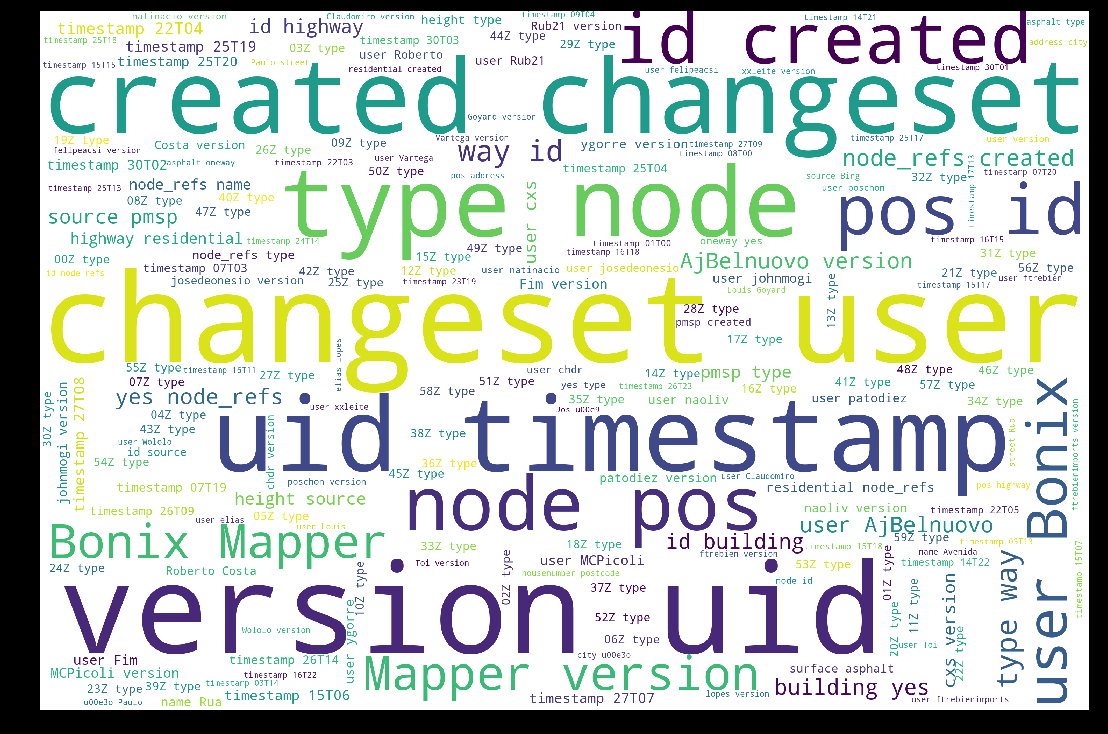

In [41]:
%matplotlib inline

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Referências Bibliográficas

https://br.answers.yahoo.com/question/index?qid=20111212182851AA8ZWJW

https://github.com/vsvasconcelos/-DW-OSM-RMSP/blob/master/DW-OSM-RMSP-rev2.ipynb

https://raw.githubusercontent.com/netoferraz/udacity/master/03_limpando_dados_do_openstreetmaps/notebook.html
        
https://github.com/YannisPap/Wrangle-OpenStreetMap-Data/blob/master/Notebook/Wrangle-OpenStreetMap-Data.ipynb
    
https://github.com/bestkao/data-wrangling-with-openstreetmap-and-mongodb
    
https://udacityopenstreetmaps.wordpress.com/2015/09/15/hello-world/
    
http://matthewdaws.github.io/
    
http://tools.geofabrik.de/osmi/

http://osmose.openstreetmap.fr/en/map/#zoom=10&lat=-23.55&lon=-46.64

https://mapzen.com/data/metro-extracts/

https://github.com/mudspringhiker/openstreetmap_datawrangling/blob/master/exploration_audit.ipynb